# Imports

In [15]:
import sys
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from modeling import load_features, test_models, print_performance, hyperparameters_tuning, add_model_to_pipeline
from exploration import read_and_split

# Preliminary modeling

We will test various models on our data in order to narrow it down to a few of the best ones, which we will later fine-tune. First we will load our preprocessed features. Implementation of load_features can be found in src/modeling.py. 

In [2]:
features = ['train_bow', 'train_tfidf', 'valid_bow', 'valid_tfidf']
features_paths = [f'../data/processed/features_{feat}.pkl' for feat in features]

features_train_bow, features_train_tfidf, features_valid_bow, features_valid_tfidf = load_features(features_paths)
_, y_train, _, y_valid, _, _ = read_and_split('../data/raw/tweets.csv')

## BOW features

Fitting LinearSVC...
Fitting time: 724.61
Prediction time: 0.03
Fitting LogisticRegression...
Fitting time: 32.05
Prediction time: 0.03
Fitting MultinomialNB...
Fitting time: 0.35
Prediction time: 0.07
Fitting ComplementNB...
Fitting time: 0.33
Prediction time: 0.07
Fitting XGBClassifier...
Fitting time: 66.82
Prediction time: 10.77


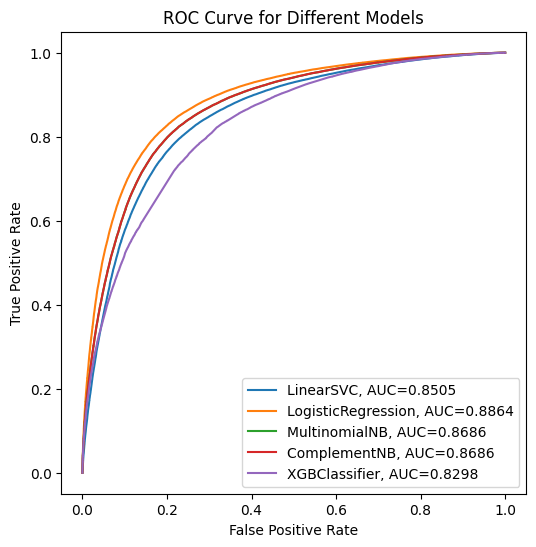

In [3]:
models = [LinearSVC(), LogisticRegression(), MultinomialNB(), ComplementNB(), XGBClassifier()]
performance = test_models(models, features_train_bow, y_train, features_valid_bow, y_valid)

In [4]:
print_performance(performance)

================LinearSVC================
Accuracy: 0.78
F1_score: 0.79
================LogisticRegression================
Accuracy: 0.81
F1_score: 0.82
================MultinomialNB================
Accuracy: 0.8
F1_score: 0.79
================ComplementNB================
Accuracy: 0.8
F1_score: 0.79
================XGBClassifier================
Accuracy: 0.75
F1_score: 0.76


## TF-IDF features

Fitting LinearSVC...
Fitting time: 75.0
Prediction time: 0.02
Fitting LogisticRegression...
Fitting time: 10.7
Prediction time: 0.02
Fitting MultinomialNB...
Fitting time: 0.32
Prediction time: 0.06
Fitting ComplementNB...
Fitting time: 0.32
Prediction time: 0.06
Fitting XGBClassifier...
Fitting time: 445.51
Prediction time: 11.02


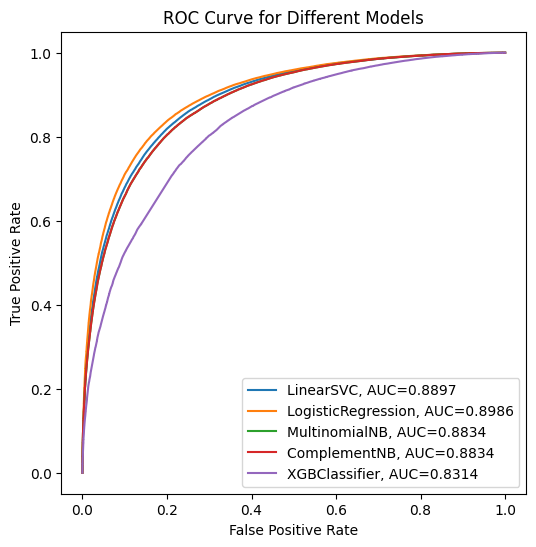

In [5]:
models = [LinearSVC(), LogisticRegression(), MultinomialNB(), ComplementNB(), XGBClassifier()]
performance = test_models(models, features_train_tfidf, y_train, features_valid_tfidf, y_valid)

In [6]:
print_performance(performance)

================LinearSVC================
Accuracy: 0.81
F1_score: 0.81
================LogisticRegression================
Accuracy: 0.82
F1_score: 0.82
================MultinomialNB================
Accuracy: 0.8
F1_score: 0.8
================ComplementNB================
Accuracy: 0.8
F1_score: 0.8
================XGBClassifier================
Accuracy: 0.75
F1_score: 0.76


From the tests above, we can see that using TF-IDF features yield better results. While LinearSVC and LogisticRegression perform the best, Naive Bayes approaches require much less computation and achieve only slightly worse results. We will tune hyperparameters for LinearSVC, LogisticRegression and MultinomialNB.

# Tuning Hyperparameters

We will use RandomizedSearchCV first to determine a promising area in the hyperparameter space. Then, we will perform GridSearchCV for a more thorough search.

## LinearSVC

### RandomSearch

In [5]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
}

model = LinearSVC()
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=10, X=features_train_tfidf, y=y_train, use_random_search=True)

Best Hyperparameters: {'tol': 0.1, 'C': 0.1}
Best ROC_AUC: 0.8842639635717242


## LogisticRegression

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(n_jobs=-1, max_iter=200)
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=-1, X=features_train_tfidf, y=y_train, use_random_search=False)

In [16]:
lr = LogisticRegression()
lr.fit(features_train_tfidf, y_train)

pickle.dump(lr, open('../models/lr_not_tuned.pkl', 'wb'))

## MultinomialNB

In [ ]:
param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 10.0],
}

model = MultinomialNB()
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=-1, X=features_train_tfidf, y=y_train, use_random_search=False)

# Adding model to pipeline

In [5]:
pipeline_file = '../models/processing_pipeline.pkl'
destination_file = '../models/model.pkl'

model = add_model_to_pipeline(pipeline_file, destination_file, lr)